In [87]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import heapq
import itertools
import copy
import os
import seaborn as sns
import pandas as pd
import cv2

In [88]:
pretrained_model = "checkpoint_model.pth" #事前学習済みMNISTモデル(重みパラメータ)
use_cuda = True

In [89]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# MNISTのTest datasetと dataloaderの定義
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
            ])), 
        batch_size=1, shuffle=False)

# 使うデバイス（CPUかGPUか）の定義
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# ネットワークの初期化
model = Net().to(device)
print(model)
# 訓練済みモデルのロード
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))


# モデルを評価モードに設定。本チュートリアルの例では、これはドロップアウト層等を評価モードにするのに必要
model.eval()

CUDA Available:  True
Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [90]:
# FGSM による攻撃用のコード
def fgsm_attack(image, epsilon, data_grad):
    # データの勾配の各要素のsign値を取得します
    sign_data_grad = data_grad.sign()
    # 入力画像の各ピクセルを調整して、ノイズが追加された画像を作成します
    perturbed_image = image + epsilon*sign_data_grad
    # [0,1]の範囲になるようデータをクリップします
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    # ノイズが追加された画像を返します
    return perturbed_image

In [91]:
def test( model, device, test_loader):

    correct1 = 0
    correct2 = 0
    count = 0
    count_list = [0] * 10

    adv_examples = []
    i=0
    dirname_grad = "../slide/grad/"
    dirname_org_T = "../slide/org/"
    dirname_adv_T = "../slide/adv_T/"
    dirname_adv_F = "../slide/adv_F/"



    # テスト用データセット内の全てのサンプルをループします
    for data, target in test_loader:
        
        # i+=1
        # if i==150:
        #     break
        # データとラベルをデバイス（CPUもしくはGPU）に送信します
        data, target = data.to(device), target.to(device)
        data = (data >= torch.Tensor([0]).to("cuda")).float() - (data < torch.Tensor([0]).to("cuda")).float()

        # テンソルの requires_grad 属性を設定します。攻撃者にとっては重要な設定です。
        data.requires_grad = True

        # データをモデルに順伝播させます
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # 最大の確率のインデックスを取得します。

        # 最初から予測が間違っている場合、攻撃する必要がないため次のイテレーションに進みます。
        if init_pred.item() != target.item() or (init_pred.item() != 7 and init_pred.item() != 8 and init_pred.item() != 9):
            continue

        # count += 1
        # print(count)
        # if count <= 433:
        #     continue
        count_list[init_pred.item()] += 1
        print(count_list[init_pred.item()])

        loss = F.nll_loss(output, target)
        # 既存の勾配を全てゼロにします
        model.zero_grad()
        # 逆伝播させてモデルの勾配を計算します
        loss.backward()
        # データの勾配を取得します
        data_grad = data.grad.data
        # FGSMによる攻撃の関数を呼び出します
        perturbed_data = fgsm_attack(data, 0.6, data_grad)
        # ノイズ付き画像を再度分類します
        output = model(perturbed_data)
        # 攻撃の成功を確認します
        final_pred1 = output.max(1, keepdim=True)[1] # log-probabilityが最大のインデックスを取得します
        org = data.squeeze().detach().cpu().numpy()
        adv = perturbed_data.squeeze().detach().cpu().numpy()

        count += 1

        for j in [dirname_grad, dirname_org_T, dirname_adv_T, dirname_adv_F]:
            for k in ["0/", "1/", "2/", "3/", "4/", "5/", "6/", "7/", "8/", "9/"]:
                os.makedirs(j + k, exist_ok=True)


        #勾配のヒートマップ
        grad_map = data_grad.squeeze().detach().cpu().numpy()
        # print(grad_map)
        plt.xticks([], [])
        plt.yticks([], [])
        grad_map[3][3] = torch.Tensor([-1]).to("cuda")
        print(grad_map)
        plt.imsave(dirname_grad + "{}/{}.png".format(init_pred.item(), count_list[init_pred.item()]), grad_map, cmap="seismic")

        #各条件を満たす画像の保存
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imsave(dirname_org_T + "{}/{}.png".format(init_pred.item(), count_list[init_pred.item()]), org, cmap="gray")
        

        if final_pred1.item() == target.item():
            correct1 += 1
            plt.xticks([], [])
            plt.yticks([], [])
            plt.imsave(dirname_adv_T + "{}/{}.png".format(init_pred.item(), count_list[init_pred.item()]), adv, cmap="gray")
        
        if final_pred1.item() != target.item():
            os.makedirs(dirname_adv_F + "{}/{}→{}/".format(init_pred.item(), init_pred.item(), final_pred1.item()), exist_ok=True)
            plt.xticks([], [])
            plt.yticks([], [])
            plt.imsave(dirname_adv_F + "{}/{}→{}/{}.png".format(init_pred.item(), init_pred.item(), final_pred1.item(), count_list[init_pred.item()]), adv, cmap="gray")
            print(init_pred.item())
            break

1
[[ 1.93436434e-10 -1.35095735e-09  4.68334982e-10 -1.68596903e-09
  -5.75930859e-10 -2.36237407e-09 -9.61750457e-10 -1.47149881e-09
   5.52591028e-11 -2.01474348e-09 -9.23216503e-10 -3.02499115e-09
  -1.99844208e-09 -2.18295182e-09 -1.53275559e-09 -1.63573688e-09
  -5.36085176e-10 -1.01710751e-09  9.94293536e-12 -1.44501133e-09
  -5.10991471e-10 -2.03012362e-09  1.14330767e-10 -1.12474408e-09
   9.34552213e-10 -6.27457392e-11 -5.24256021e-11  0.00000000e+00]
 [-8.92448615e-10 -1.18518917e-09 -5.97563804e-11 -1.29241129e-09
  -5.86045878e-10 -1.94123673e-09  1.13400789e-09 -1.38437573e-09
   5.43462608e-10 -2.16092477e-09 -2.07056461e-09 -3.76515930e-09
  -2.43871301e-09 -2.56878985e-09 -7.94580457e-10 -1.20986943e-09
   3.76496334e-10 -2.86085981e-11 -7.40733641e-10 -1.23888666e-09
  -1.94308813e-09 -1.47325629e-09  7.26776417e-10 -1.75534656e-11
   2.02052508e-09  5.27999033e-11  5.45808565e-10  0.00000000e+00]
 [-3.00126723e-09 -4.30636549e-09 -6.13128881e-09 -9.26543819e-09
  -8.3

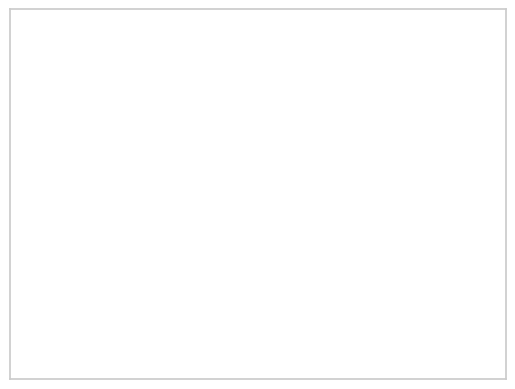

In [92]:
test(model, device, test_loader)
# accuracies = []
# examples = []

# # 各epsilonごとにテストを実行
# acc, ex = test(model, device, test_loader)
# accuracies.append(acc)
# examples.append(ex)

In [93]:
# cnt = 0
# plt.figure(figsize=(8,10))

# for j in range(len(examples[0])):
#     cnt += 1
#     plt.subplot(5,5,cnt)
#     plt.xticks([], [])
#     plt.yticks([], [])
#     orig,adv, org_ex, adv_ex = examples[0][j]
#     plt.title("{}".format(orig), color="white")
#     plt.imshow(org_ex, cmap="gray")
# plt.tight_layout()
# plt.show()

In [94]:
# cnt = 0
# plt.figure(figsize=(8,10))

# for j in range(len(examples[0])):
#     cnt += 1
#     plt.subplot(5,5,cnt)
#     plt.xticks([], [])
#     plt.yticks([], [])
#     orig, adv, org_ex, adv_ex = examples[0][j]
#     plt.title("{} -> {}".format(orig, adv), color="white")
#     plt.imshow(adv_ex, cmap="gray")
# plt.tight_layout()
# plt.show()